### Imports

In [2]:
# Datamanipulation 
import pandas as pd
import numpy as np
# Working with images
import cv2
# Path tools
import glob
import os
# Stringmatching
from fuzzywuzzy import fuzz
# Visualization
from matplotlib import pyplot as plt

import json

/Users/marcworner/opt/anaconda3/envs/ski_extract/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Functions

In [3]:
def compare_frames_screenshot_with_matchTemplate(video_path, screenshot_path):
    """ For a given video and screenshot this function returns the frame of the video 
    with the highest simmilarity to the screenshot using openCV matchTemplate"""

    screenshot = cv2.imread(screenshot_path, cv2.IMREAD_GRAYSCALE)
    video = cv2.VideoCapture(video_path)
    highest_match_score = 0
    highscore_frame = 0

    for i in range(0,int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, extracted_frame = video.read()

        if not success:
            print(f"Warning: Could not read frame {i}")
            continue
        
        extracted_frame_gray = cv2.cvtColor(extracted_frame, cv2.COLOR_BGR2GRAY)

        result = cv2.matchTemplate(extracted_frame_gray, screenshot, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > highest_match_score:
            highest_match_score = max_val
            highscore_frame = i

    print(f"frame number: {highscore_frame} has the highest score with:  {highest_match_score}")


    return highest_match_score, highscore_frame

def compare_frames_screenshot_with_orb(video_path, screenshot_path):
    """
    For a given video and screenshot, this function returns the frame of the video
    with the highest similarity to the screenshot using ORB feature matching.
    """
    screenshot = cv2.imread(screenshot_path, cv2.IMREAD_GRAYSCALE)
    if screenshot is None:
        raise ValueError("Screenshot image could not be loaded. Check the path.")
    
    # Initialize ORB detector
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(screenshot, None)
    if des1 is None:
        raise ValueError("No descriptors found in the screenshot.")

    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        raise ValueError("Video could not be opened. Check the path.")
    
    highest_match_score = 0
    highscore_frame = 0

    # BFMatcher for descriptor matching
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    for i in range(int(video.get(cv2.CAP_PROP_FRAME_COUNT))):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        success, extracted_frame = video.read()

        if not success:
            print(f"Warning: Could not read frame {i}")
            continue
        
        extracted_frame_gray = cv2.cvtColor(extracted_frame, cv2.COLOR_BGR2GRAY)

        # Detect ORB features in the current frame
        kp2, des2 = orb.detectAndCompute(extracted_frame_gray, None)
        if des2 is None:
            print(f"Warning: No descriptors found in frame {i}")
            continue
        
        # Match descriptors between screenshot and frame
        matches = bf.match(des1, des2)
        match_score = len(matches)  # Number of good matches

        if match_score > highest_match_score:
            highest_match_score = match_score
            highscore_frame = i

    print(f"Frame number: {highscore_frame} has the highest score with: {highest_match_score} matches.")

    return highest_match_score, highscore_frame

def part_of_frame_check(extracted_frame, screenshot):

    result = cv2.matchTemplate(extracted_frame, screenshot, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    print(max_val)

def plot_frame(image):

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Plot the image with matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis
    plt.title("Image from OpenCV")
    plt.show()


### Sort, filter and structure videos and images 

- Some videos are represented two times, these have a "_lg" tag 

In [4]:
path_to_images = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/"
skier_images = glob.glob(path_to_images + "*.jpg")

path_to_videos = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/"
skier_videos = glob.glob(path_to_videos + "*.[mM][pP]4") + glob.glob(path_to_videos + "*.[mM][oO][vV]")
skier_videos = [video for video in skier_videos if "_lq" not in video] # exclude all videos containing "_lq" to avoid double videos

image_file_names = []
video_file_names = []

for image_path in skier_images:
    file_name_with_extension = os.path.basename(image_path)
    image_file_names.append(file_name_with_extension)

for video_path in skier_videos:
    file_name_with_extension = os.path.basename(video_path)
    video_file_names.append(file_name_with_extension)

### Generation of a dictionary containing video names (keys) with 5 matching label imagenames (values) 

In [5]:
videos_and_images_dict = {}

for video_string in video_file_names:
    images_per_vid_dict = {}
    for image_string in image_file_names:
        score = fuzz.ratio(video_string, image_string) # fuzzywuzzy used to compare simmilarity of strings
        images_per_vid_dict[image_string] = score

    top_5 = dict(sorted(images_per_vid_dict.items(), key=lambda item: item[1], reverse=True)[:5])
    key_list = list(top_5.keys())

    videos_and_images_dict[video_string] = key_list


### Find label frames in video 

#### Option 1 

In [ ]:
path_to_screenshot = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/" + videos_and_images_dict['Hermann Noemi.mp4'][1]
path_to_frame = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/" + "Hermann Noemi.mp4"

compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)

frame number: 63 has the highest score with:  0.9992833137512207


(0.9992833137512207, 63)

#### Option 2

In [101]:
compare_frames_screenshot_with_orb(path_to_frame, path_to_screenshot)

Frame number: 63 has the highest score with: 329 matches.


(329, 63)

### Generation of dict containing Video and Label Frames 
- Iteration over videos_and_images_dict to find the highscoreframe which is the full label frame 

In [ ]:
label_frames_dict = {
    "videos": []
}

for key, value in videos_and_images_dict.items():

    single_video_dict = {
        "videoname": key,
        "frame_details": []
    }

    for screenshot in range(len(value)):
        
        frame_detail_dict = {}

        path_to_frame = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/" + key
        path_to_screenshot = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/" + videos_and_images_dict[key][screenshot]
        
        # compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)
        highest_match_score, highscore_frame = compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)

        frame_detail_dict["frame_number"] = highscore_frame
        frame_detail_dict["score"] = highest_match_score
        frame_detail_dict["image_name"] = videos_and_images_dict[key][screenshot]

        single_video_dict["frame_details"].append(frame_detail_dict)
    
    label_frames_dict["videos"].append(single_video_dict)

with open("LabelFrames.json", "w") as json_file:
    json.dump(label_frames_dict, json_file, indent=4)


'\nlabel_frames_dict = {\n    "videos": []\n}\n\nfor key, value in videos_and_images_dict.items():\n\n    single_video_dict = {\n        "videoname": key,\n        "frame_details": []\n    }\n\n    for screenshot in range(len(value)):\n        \n        frame_detail_dict = {}\n\n        path_to_frame = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/" + key\n        path_to_screenshot = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/" + videos_and_images_dict[key][screenshot]\n        \n        # compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)\n        highest_match_score, highscore_frame = compare_frames_screenshot_with_matchTemplate(path_to_frame, path_to_screenshot)\n\n        frame_detail_dict["frame_number"] = highscore_frame\n        frame_detail_dict["score"] = highest_match_score\n        frame_detail_dict["image_name"] = videos_and_images_dict[key][screenshot]\n\n        single_video_dict[

### Testing of frame screenshot match

0.9993300437927246


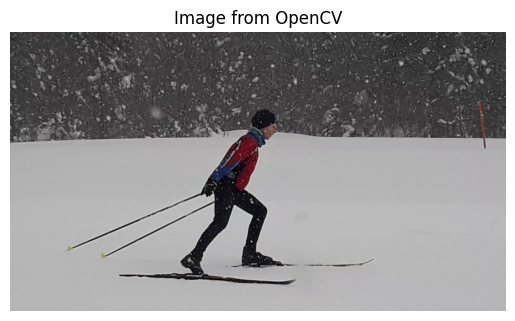

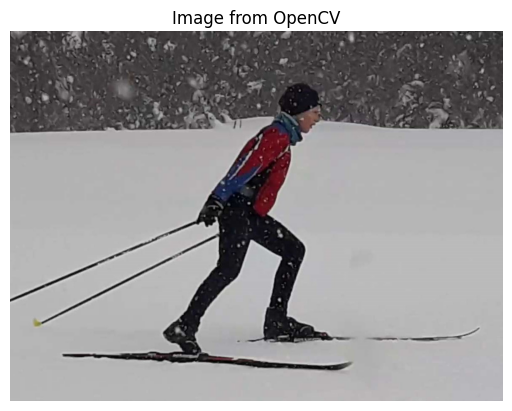

In [142]:
path_to_screenshot = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/pictures/lateral/" + videos_and_images_dict['Klauser Hannes.mp4'][0]
screenshot = cv2.imread(path_to_screenshot, cv2.IMREAD_COLOR)

path_to_frame = "/Volumes/ThesisUSB/AVP XC Skiing Data/Skating 2-1 armswing/videos/lateral/" + "Klauser Hannes.mp4"
test_cap = cv2.VideoCapture(path_to_frame)

test_cap.set(cv2.CAP_PROP_POS_FRAMES, 42)
ret, extracted_frame = test_cap.read()

part_of_frame_check(extracted_frame, screenshot)
plot_frame(extracted_frame)
plot_frame(screenshot)
